<center>
    <h3>Name: Kevin Alexander Aslesen</h3>
    <h3>Username: kevinaas</h3>
</center>

# Introduction

In this assignment we look at different ways for classifing data, first binary and the multi-class. Some methods are easier to implement than others, like the linear and logistic regression classifier. While other are much more techniqual, like neural networks, but they tend to give better results than the simpler ones. The code bellow imports the necessary libraries, generates our data points and splits it into train, validation and test sets. It's identical to the code given in the assignment.

-----

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Generating the dataset
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400, 400, 400, 400, 400], centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                  n_features=2, random_state=2024, cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5])

In [3]:
# Shuffling the dataset
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2024)
rng.shuffle(indices)

In [4]:
# Splitting into train, dev and test
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]

In [5]:
# Multi-class target
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

In [6]:
# Binary target
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

-----

# Part 1: Linear Classifiers
## Linear Regression

The following code is given in the assignment and defines the linear regression classifier that we will now use. The code also includes a function for calculating the accuarcy and a function for plotting the descision boundary, in which I have only done minor adjustments.

-----------

In [7]:
def add_bias(X, bias):
    """X is a NxM matrix: N datapoints, M features
    bias is a bias term, -1 or 1, or any other scalar. Use 0 for no bias
    Return a Nx(M+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1)) * bias # Make a N*1 matrix of biases
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [8]:
class NumpyClassifier():
    """Common methods to all Numpy classifiers --- if any"""

In [9]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a NxM matrix, N data points, M features
        t_train is avector of length N,
        the target class values for the training data
        lr is our learning rate
        """
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, M) = X_train.shape
        
        self.weights = weights = np.zeros(M)
        
        for epoch in range(epochs):
            # print("Epoch", epoch)
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
    
    def predict(self, X, threshold=0.5):
        """X is a KxM matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

In [10]:
def accuracy(predicted, gold):
    """Return the accuracy of the predicted values and the actual values (gold)"""
    return np.mean(predicted == gold)

In [11]:
def plot_decision_regions(X, t, clf=[], size=(12,8)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a prediction of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size)

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.3)

    plt.scatter(X[:,0], X[:,1], c=t, s=20.0, alpha=0.5)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

--------

Here is the initial classifier which was done in the assignment text with its accuracy and decision boundary

Accuracy on the validation set: 0.58


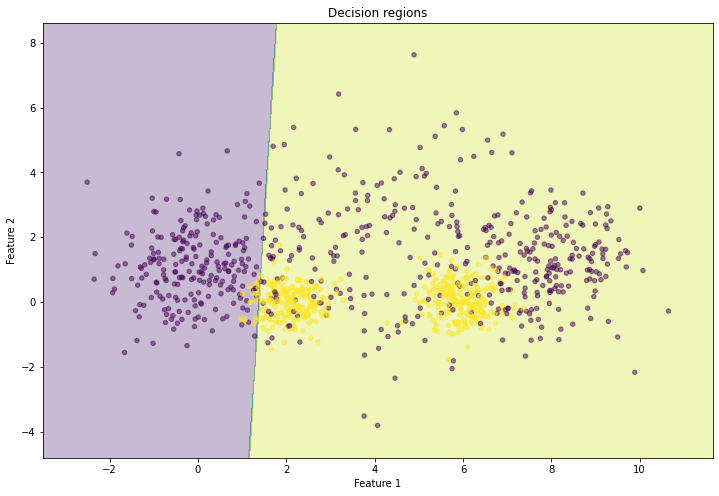

In [12]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, epochs=3)
print("Accuracy on the validation set:", accuracy(cl.predict(X_val), t2_val))
plot_decision_regions(X_train, t2_train, cl)

It's not that great.

## Task: Tuning

Out first task is to tune the hyper-parameters $\eta$ (eta / learning rate) and _epochs_ (number of iterations). We do this by first choosing a range for both $\eta$ and _epochs_ that we want to check. Then for every $\eta$, we will go through every epoch and calculate the accuray of the linear classifier which was trained with the current hyper-parameters. The smallest epoch which gave the best accuracy is printet out along with the current $\eta$ and the accuracy. This process is defined with the following function:

In [13]:
def test_rate_epochs(eta_range, epoch_range, X_train=X_train, X_val=X_val):
    print('+---------------+--------+----------+')
    print('| Learning rate | Epochs | Accuracy |')
    print('+---------------+--------+----------+')
    for e in eta_range:
        best = None
        for epoch in epoch_range:
            cl = NumpyLinRegClass()
            cl.fit(X_train, t2_train, eta=e, epochs=epoch)
            acc = accuracy(cl.predict(X_val), t2_val)
            if (best == None):
                best = (epoch, acc)
            elif (acc > best[1]):
                best = (epoch, acc)
        print(f'|{e:10.4f}     | {best[0]:5}  |   {best[1]:.3f}  |')
    print('+---------------+--------+----------+')

Let us just initialy set $\eta \in$ (0.01, 0.02, ..., 0.1) and _epochs_ $\in$ (10, 20, ..., 1000):

In [14]:
eta_range = np.arange(1, 11)/100
epoch_range = range(10, 1010, 10)
test_rate_epochs(eta_range, epoch_range)

+---------------+--------+----------+
| Learning rate | Epochs | Accuracy |
+---------------+--------+----------+
|    0.0100     |   930  |   0.750  |
|    0.0200     |   990  |   0.760  |
|    0.0300     |   660  |   0.760  |
|    0.0400     |   500  |   0.760  |
|    0.0500     |   400  |   0.760  |
|    0.0600     |   330  |   0.760  |
|    0.0700     |   280  |   0.760  |
|    0.0800     |    10  |   0.604  |
|    0.0900     |    10  |   0.572  |
|    0.1000     |    10  |   0.542  |
+---------------+--------+----------+


The winner here is $\eta$ = 0.07 and _epochs_ = 280, since these give the highest accuracy and are least computational demanding (fewest epochs). Since the accuracy seems to decline as the learning rate goes toward 0.01 and 0.1, we will not widen out search for $\eta$. Instead we focus on the values between 0.07 and 0.08 to see if we can find better values for the parameters.

In [15]:
eta_range = np.arange(70, 81)/1000 
epoch_range = range(10, 1010, 10)
test_rate_epochs(eta_range, epoch_range)

+---------------+--------+----------+
| Learning rate | Epochs | Accuracy |
+---------------+--------+----------+
|    0.0700     |   280  |   0.760  |
|    0.0710     |   280  |   0.760  |
|    0.0720     |   280  |   0.760  |
|    0.0730     |   270  |   0.760  |
|    0.0740     |   270  |   0.760  |
|    0.0750     |   260  |   0.760  |
|    0.0760     |   260  |   0.760  |
|    0.0770     |   260  |   0.760  |
|    0.0780     |   260  |   0.760  |
|    0.0790     |   900  |   0.766  |
|    0.0800     |    10  |   0.604  |
+---------------+--------+----------+


We see that $\eta$ = 0.079 and _epochs_ = 900 is the best in terms of accuracy with 76.6%, but it is only 0.6% higher than $\eta$ = 0.078 and _epochs_ = 260 which has less than a third of the amount of iterations. Since this dataset isn't that big, I think we can just stick with the former:

In [16]:
eta = 0.079
epochs = 900

Let's see the decision boundary that these parameters give to the linear classifier:

Accuracy on the validation set: 0.766


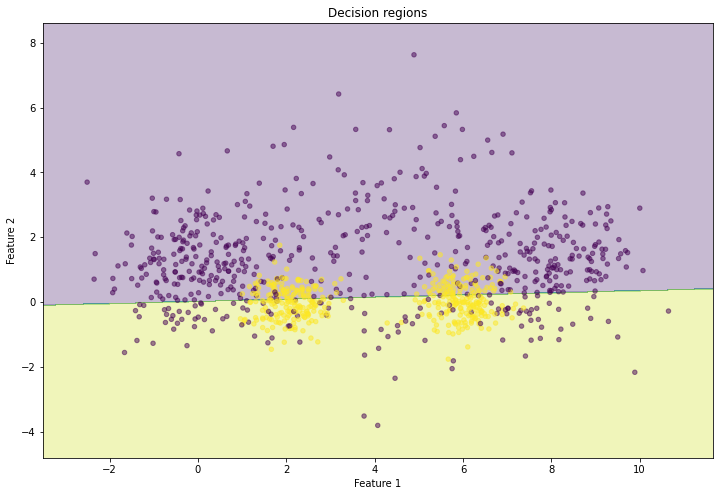

In [17]:
cl_tuned = NumpyLinRegClass()
cl_tuned.fit(X_train, t2_train, eta=0.079, epochs=900)
print("Accuracy on the validation set:", accuracy(cl_tuned.predict(X_val), t2_val))
plot_decision_regions(X_train, t2_train, cl_tuned)

Wow, this looks much better than the initial classifier in the introduction.

## Task: Scaling

We will scale the data by using the standard scaler (normalizer), which is defined by the following function:

In [18]:
def normScaler(X):
    return (X - np.mean(X)) / np.std(X)

Let's scale the training and validation sets

In [19]:
X_train_s = normScaler(X_train)
X_val_s = normScaler(X_val)

We can now make a linear classifier on the scaled data and calculate the accuarcy on the scaled validation set using the same hyper-parameters we found above:

In [20]:
cl_s = NumpyLinRegClass()
cl_s.fit(X_train_s, t2_train, eta=eta, epochs=epochs)
acc = accuracy(cl_s.predict(X_val_s), t2_val)
print("Accuracy on the validation set:", acc)

Accuracy on the validation set: 0.776


This is an improvment of 1% compared to the unscaled data. Let's try and tune the hyper parameters again to see if we can get a better score.

In [21]:
eta_range = np.arange(1, 11)/100
epoch_range = range(10, 1000, 10)
test_rate_epochs(eta_range, epoch_range, X_train_s, X_val_s)

+---------------+--------+----------+
| Learning rate | Epochs | Accuracy |
+---------------+--------+----------+
|    0.0100     |   920  |   0.762  |
|    0.0200     |   750  |   0.770  |
|    0.0300     |   770  |   0.774  |
|    0.0400     |   860  |   0.776  |
|    0.0500     |   690  |   0.776  |
|    0.0600     |   570  |   0.776  |
|    0.0700     |   490  |   0.776  |
|    0.0800     |   430  |   0.776  |
|    0.0900     |   380  |   0.776  |
|    0.1000     |   350  |   0.776  |
+---------------+--------+----------+


The accuracy is much more stable, and it seems like the accuracy becomes better when the learning rate increases and the number of epochs decreases. Lets see how this continous:

In [22]:
eta_range = np.arange(10, 121, 10)/100 
epoch_range = range(10, 1000, 10)
test_rate_epochs(eta_range, epoch_range, X_train_s, X_val_s) 

+---------------+--------+----------+
| Learning rate | Epochs | Accuracy |
+---------------+--------+----------+
|    0.1000     |   350  |   0.776  |
|    0.2000     |   170  |   0.776  |
|    0.3000     |   120  |   0.776  |
|    0.4000     |    90  |   0.776  |
|    0.5000     |    70  |   0.776  |
|    0.6000     |    60  |   0.776  |
|    0.7000     |    50  |   0.776  |
|    0.8000     |    50  |   0.776  |
|    0.9000     |    50  |   0.776  |
|    1.0000     |    20  |   0.582  |
|    1.1000     |    10  |   0.564  |
|    1.2000     |    10  |   0.556  |
+---------------+--------+----------+


We see that a learning rate between 0.7 and 0.9 does not change the number of _epochs_ used to get the same accuracy. Whatsmore, the accuracy starts to drop when the learning rate reaches 1. Let us look closer between 0.9 and 1, and also try to fine tune number of epochs:

In [23]:
eta_range = np.arange(850, 1010, 10)/1000 
epoch_range = range(10, 500, 1)
test_rate_epochs(eta_range, epoch_range, X_train_s, X_val_s)

+---------------+--------+----------+
| Learning rate | Epochs | Accuracy |
+---------------+--------+----------+
|    0.8500     |    11  |   0.778  |
|    0.8600     |    11  |   0.778  |
|    0.8700     |    11  |   0.782  |
|    0.8800     |    15  |   0.782  |
|    0.8900     |    17  |   0.782  |
|    0.9000     |    21  |   0.784  |
|    0.9100     |    19  |   0.782  |
|    0.9200     |    23  |   0.782  |
|    0.9300     |    37  |   0.784  |
|    0.9400     |    49  |   0.784  |
|    0.9500     |    51  |   0.784  |
|    0.9600     |    87  |   0.784  |
|    0.9700     |   291  |   0.784  |
|    0.9800     |    11  |   0.598  |
|    0.9900     |    11  |   0.584  |
|    1.0000     |    16  |   0.582  |
+---------------+--------+----------+


With a more fine tuned number of epochs we are able to get better accuracies. From 0.90 we see that the accuracy doesnt increase anymore. At 0.97 the number of epochs increases alot for the same accuracy, and at 0.98 the accuracy falls alot meaning we overshoot. The best values for parameters are then $\eta$ = 0.9 and _epochs_ = 21. Lets use these to make a classifier and plot the result.

Accuracy on the validation set: 0.784


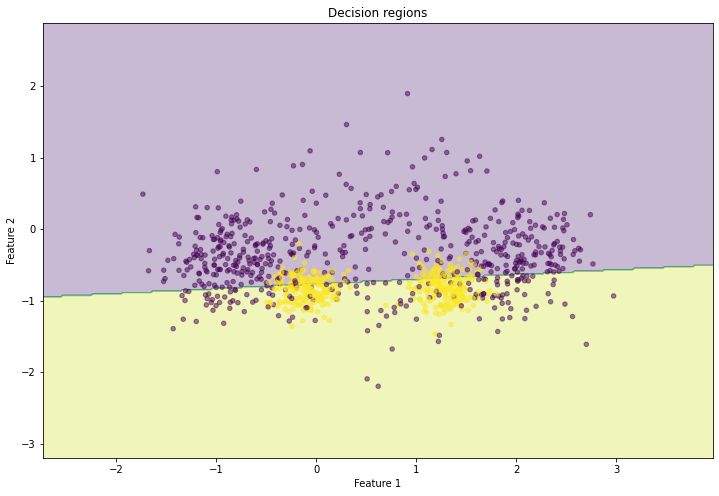

In [24]:
eta = 0.9
epochs = 21
cl_s = NumpyLinRegClass()
cl_s.fit(X_train_s, t2_train, eta=eta, epochs=epochs)
acc = accuracy(cl_s.predict(X_val_s), t2_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train_s, t2_train, cl_s)

It's not easy to see any difference from the previous plot, but the accuracy says that this is 2% better and we know its more effective because of small number of iterations (21) compared to over 900 for the unscaled case.

## Logistic Regression


We will now try out the logistic regression classifier, and for this we first need the logistic function so that we can implementing it in the classifier:

In [25]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

Our classifier will then look like this:

In [26]:
class LogisticRegressionClassifier():

    def fit(self, X_train, t_train, X_val=None, t_val=None, eta=0.1, tol=1e-3, n_epochs_no_update=5):
        N, m = np.shape(X_train)
        X = add_bias(X_train, -1)
        self.weights = np.zeros(m+1)
        
        self.losses = losses = []
        self.accuracies = accuracies = []
        self.val_losses = val_losses = []
        self.val_accuracies = val_accuracies = []
        
        self.epochs = 0
        prev_loss = 0
        no_update = 0
        while (no_update < n_epochs_no_update):
            # Update weights
            y = self.predict_probability(X)
            self.weights -= eta/N * X.T @ (y - t_train)
            
            # Calcuate the cross-entropy loss and accuracy:
            y = self.predict_probability(X)
            loss = -np.sum(t_train * np.log(y) + (1-t_train) * np.log(1 - y))
            acc = accuracy(self.predict(X_train), t_train)
            
            # Store the loss and accuracy
            losses.append(loss)
            accuracies.append(acc)
            
            if isinstance(X_val, np.ndarray) and isinstance(t_val, np.ndarray):
                # If we are given validation set:
                y = self.predict_probability(add_bias(X_val,-1))
                val_loss = -np.sum(t_val * np.log(y) + (1-t_val)*np.log(1 - y))
                val_acc = accuracy(self.predict(X_val), t_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
            
            # Check if the loss has changed significantly
            if (abs(loss - prev_loss) < tol):
                no_update += 1
            else:
                no_update = 0
                
            # Update loss and amount of epochs
            prev_loss = loss
            self.epochs += 1

    def predict(self, X):
        Z = add_bias(X, -1)
        p = self.predict_probability(Z)
        return np.where(p > 0.5, 1, 0)
    
    def predict_probability(self, X):
        return logistic(X @ self.weights)

To find the best learning rate ($\eta$) and tolerance (_tol_) for this classifier we will make use of the following function, which is similar to the one we used in the linear regression classifier, but I have switched the _epochs_ with the _tol_  hyper-paramter instead:

In [27]:
def test_rate_tol(eta_range, tol_range, X_train=X_train, X_val=X_val):
    print('+---------------+--------+----------+')
    print('| Learning rate |  Tol   | Accuracy |')
    print('+---------------+--------+----------+')
    for e in eta_range:
        best = None
        for t in tol_range:
            log_cl = LogisticRegressionClassifier()
            log_cl.fit(X_train, t2_train, eta=e, tol=t)
            acc = accuracy(log_cl.predict(X_val), t2_val)
            if (best == None):
                best = (t, acc)
            elif (acc > best[1]):
                best = (t, acc)
        print(f'|{e:10.4f}     | {best[0]:5}  |   {best[1]:.3f}  |')
    print('+---------------+--------+----------+')

Lets first look at $\eta \in$ (0.01, 0.04, ..., 0.4) and _tol_ $\in$ (0.1, 0.11, ..., 1.0) 

In [28]:
eta_range = np.arange(1, 41, 3)/100
tol_range = np.arange(10, 101)/100
test_rate_tol(eta_range, tol_range)

+---------------+--------+----------+
| Learning rate |  Tol   | Accuracy |
+---------------+--------+----------+
|    0.0100     |   0.1  |   0.760  |
|    0.0400     |  0.23  |   0.762  |
|    0.0700     |  0.42  |   0.762  |
|    0.1000     |  0.63  |   0.762  |
|    0.1300     |   0.9  |   0.762  |
|    0.1600     |  0.68  |   0.758  |
|    0.1900     |  0.85  |   0.758  |
|    0.2200     |  0.25  |   0.756  |
|    0.2500     |   0.1  |   0.754  |
|    0.2800     |  0.35  |   0.756  |
|    0.3100     |   0.1  |   0.754  |
|    0.3400     |   0.1  |   0.754  |
|    0.3700     |  0.33  |   0.756  |
|    0.4000     |  0.57  |   0.764  |
+---------------+--------+----------+


It seems like the accuracy increases at the end of the list, so lets try increasing the training rate a bit, say $\eta \in$ (0.4, 0.405, ..., 0.45)

In [29]:
eta_range = np.arange(400, 455, 5)/1000
tol_range = np.arange(10, 101)/ 100
test_rate_tol(eta_range, tol_range)

+---------------+--------+----------+
| Learning rate |  Tol   | Accuracy |
+---------------+--------+----------+
|    0.4000     |  0.57  |   0.764  |
|    0.4050     |  0.49  |   0.766  |
|    0.4100     |  0.45  |   0.764  |
|    0.4150     |   0.1  |   0.764  |
|    0.4200     |  0.31  |   0.764  |
|    0.4250     |  0.25  |   0.764  |
|    0.4300     |  0.17  |   0.766  |
|    0.4350     |  0.14  |   0.766  |
|    0.4400     |   0.1  |   0.770  |
|    0.4450     |   0.1  |   0.768  |
|    0.4500     |   0.1  |   0.760  |
+---------------+--------+----------+


The accuracy drops toward the end at 0.45 and we were able to get better accuracies than before; the best being 77.0% with $\eta$ = 0.44 and _tol_ = 0.1. But do note, initialy I tried to test learning rates towards 0.5, but everytime the value crossed 0.45 the kernel kept going indefinetly. This suggest that the logistic regression overshoots and never converge when the learning rate is so high, meaning we should go for a smaller $\eta$. The parameter pair that had the highest accuracy (76.2%) and biggest tolerance (meaning less computational demanding) was:

In [30]:
eta = 0.13
tol = 0.9

Let us also quickly see the effect scaling the data has on the accuracy:

In [63]:
eta_range = np.arange(1, 41, 3)/100
tol_range = np.arange(10, 101)/100
test_rate_tol(eta_range, tol_range, X_train_s, X_val_s) 

+---------------+--------+----------+
| Learning rate |  Tol   | Accuracy |
+---------------+--------+----------+
|    0.0100     |  0.12  |   0.600  |
|    0.0400     |   0.1  |   0.752  |
|    0.0700     |   0.1  |   0.766  |
|    0.1000     |   0.1  |   0.766  |
|    0.1300     |   0.1  |   0.770  |
|    0.1600     |  0.13  |   0.770  |
|    0.1900     |  0.15  |   0.770  |
|    0.2200     |  0.17  |   0.770  |
|    0.2500     |   0.2  |   0.770  |
|    0.2800     |  0.22  |   0.770  |
|    0.3100     |  0.25  |   0.770  |
|    0.3400     |  0.27  |   0.770  |
|    0.3700     |   0.3  |   0.770  |
|    0.4000     |  0.32  |   0.770  |
+---------------+--------+----------+


This gives consistently better results on the accuracy when the learning rate is over 0.1, meaning we should use the scaled data for training the classifer. We should not choose a learning rate near 0.40 because of possible overshooting and instability, while choosing a smaller learning rate towards 0.1 would be more computational demanding. Choosing a learning rate in the middle of these in table doesent seem like a bad idea, meaning our best parameters are:

In [58]:
eta = 0.25
tol = 0.2

Now, lets fit our logistic classifier with these parameters

In [59]:
log_cl = LogisticRegressionClassifier()

log_cl.fit(X_train_s, t2_train, X_val_s, t2_val, eta=eta, tol=tol)
training_loss = log_cl.losses
training_acc = log_cl.accuracies
validation_loss = log_cl.val_losses
validation_acc = log_cl.val_accuracies

and plot the losses and accuracies that were calculated for both the training and validation set:

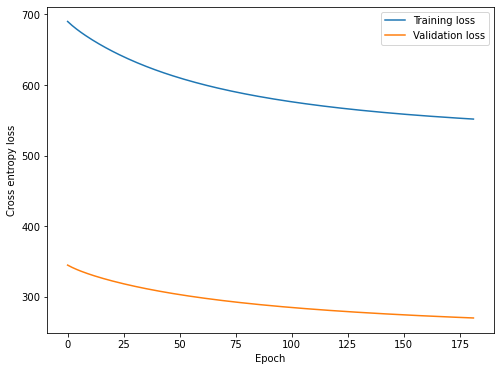

In [60]:
plt.figure(figsize=(8,6))
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')
plt.legend()
plt.show()

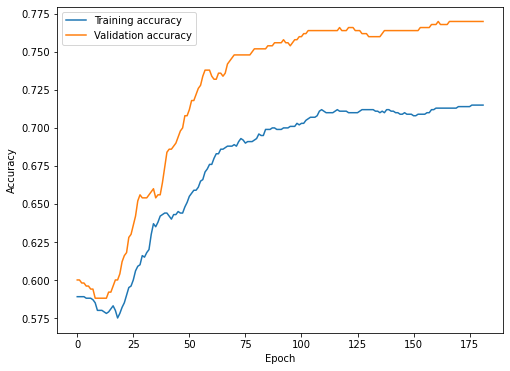

In [61]:
plt.figure(figsize=(8,6))
plt.plot(training_acc, label='Training accuracy')
plt.plot(validation_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The loss graphs are definitely monotone, which is as expected because the cross entropy loss is a convex function. But, the training and validation seems to be flipped in terms of what I thought was expected for both the loss and accuracy. The loss for the training is much higher than the loss for the validation set, where the opposite is usually expected because the model is trained on the training set if I'm not mistaken. The same goes for the accuracy, in which the accuracy for the validation set is always better than that for the training set in every epoch. This could maybe stem from some sort of implementaion flaw in the code, or maybe I'm wrong and this is how it's supposed to be.

Out of curiosity, lets plot the decision boundary for the logistic classifier

Accuracy on the validation set: 0.77


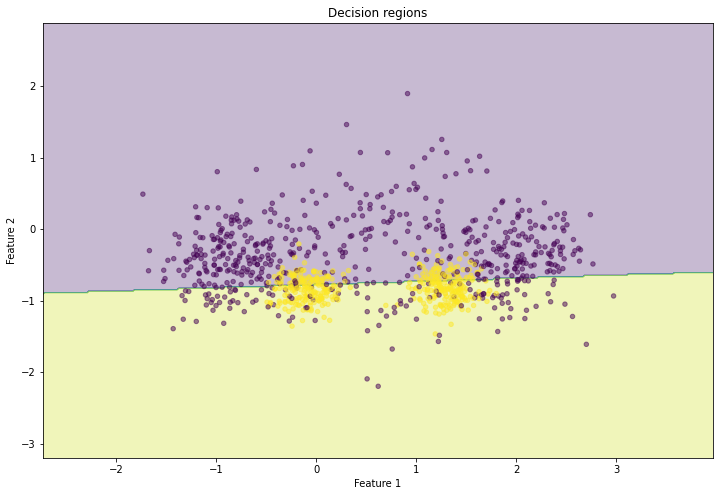

In [36]:
log_cl = LogisticRegressionClassifier()
log_cl.fit(X_train_s, t2_train, eta=eta, tol=tol)
acc = accuracy(log_cl.predict(X_val_s), t2_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train_s, t2_train, log_cl)

Looks quite similar to the one we got from the linear regression classifier.

## Multi-class classifer
### "One-vs-rest" with logistic regression

It's time for some multi-class classification and we start with the 'one-vs-rest' classifier, which essentially fits a logistic regression classifier for each class and then predicts the class of a point by the probability of it being in each class. The following code does exactly this:

In [37]:
class MultiClassLogRegClassifier():
    
    def fit(self, X_train, t_train, eta=0.1, tol=2, n_epochs_no_update=5):
        # One-hot encode the target data:
        self.n_class = n_class = 5
        t_one_hot = np.zeros((t_train.shape[0], n_class))
        for i, t_class in enumerate(t_train):
            t_one_hot[i][t_class] = 1
            
        # Create a list of untrained logistic classifiers for each class
        self.classifiers = classifiers = [LogisticRegressionClassifier() for x in range(n_class)]
        
        # Train each classifier with their corresponding one-hot target column
        for i, cl in enumerate(classifiers):
            cl.fit(X_train, t_one_hot[:,i], eta=eta, tol=tol)
            
    def predict(self, X):
        # Choose the class with the highest probability
        Z = add_bias(X, -1)
        return np.argmax(self.predict_probability(Z), axis=1)
    
    def predict_probability(self, X):
        """Fills each column of a matrix with the predicted probability for being
        in one class given a input X and retruns it"""
        prob_matrix = np.zeros((X.shape[0], self.n_class))
        for j in range(self.n_class):
            prob_matrix[:,j] = self.classifiers[j].predict_probability(X)
        return prob_matrix

Before fitting the model lets again tune the hyper parameters. This time though, letting the learning rate be constant and loop through different values for _tol_:

In [38]:
tol_range = np.array([0.001, 0.01, 0.1, 1, 10])
e = 0.1
print('+---------------+---------+----------+')
print('| Learning rate |   Tol   | Accuracy |')
print('+---------------+---------+----------+')
for t in tol_range:
    cl = MultiClassLogRegClassifier()
    cl.fit(X_train, t_multi_train, eta=e, tol=t)
    acc = accuracy(cl.predict(X_val), t_multi_val)
    print(f'|{e:10.2f}     |  {t:5}  |   {acc:.3f}  |')
print('+---------------+---------+----------+')

+---------------+---------+----------+
| Learning rate |   Tol   | Accuracy |
+---------------+---------+----------+
|      0.10     |  0.001  |   0.860  |
|      0.10     |   0.01  |   0.850  |
|      0.10     |    0.1  |   0.824  |
|      0.10     |    1.0  |   0.596  |
|      0.10     |   10.0  |   0.350  |
+---------------+---------+----------+


We see that the accuracy drops significantly as _tol_ becomes larger, which is expected since the classifier then allows for a larger gap in the loss between each of iteration of traning before terminating. We let _tol_ = 0.001 which gives the best accuracy in exchange for a more demanding computation. Now we can let the tolerance be fixed and then go through different values for $\eta$:

In [39]:
eta_range = np.array([0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35])
t = 0.001
print('+---------------+---------+----------+')
print('| Learning rate |   Tol   | Accuracy |')
print('+---------------+---------+----------+')
for e in eta_range:
    cl = MultiClassLogRegClassifier()
    cl.fit(X_train, t_multi_train, eta=e, tol=t)
    acc = accuracy(cl.predict(X_val), t_multi_val)
    print(f'|{e:10.2f}     |  {t:5}  |   {acc:.3f}  |')
print('+---------------+---------+----------+')

+---------------+---------+----------+
| Learning rate |   Tol   | Accuracy |
+---------------+---------+----------+
|      0.01     |  0.001  |   0.850  |
|      0.05     |  0.001  |   0.858  |
|      0.10     |  0.001  |   0.860  |
|      0.15     |  0.001  |   0.862  |
|      0.20     |  0.001  |   0.862  |
|      0.25     |  0.001  |   0.860  |
|      0.30     |  0.001  |   0.860  |
|      0.35     |  0.001  |   0.860  |
+---------------+---------+----------+


The best accuracies are at learning rates 0.15 and 0.2, where we choose $\eta$ = 0.2 for relieving some of the computation that we got from choosing the smaller tolerance. Now we can fit the multi-class classifier and plot the decision bounderies:

Accuracy on the validation set: 0.862


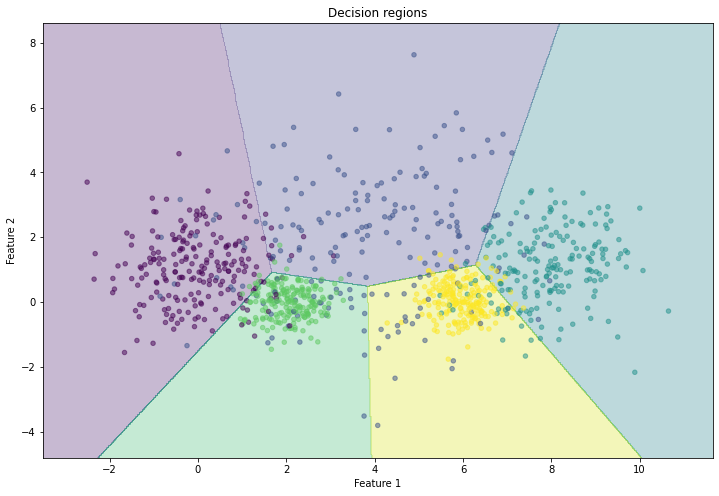

In [40]:
multi_cl = MultiClassLogRegClassifier()
multi_cl.fit(X_train, t_multi_train, eta=0.2, tol=0.001)
acc = accuracy(multi_cl.predict(X_val), t_multi_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train, t_multi_train, multi_cl)

Wow, this looks great! The classes are clearly seperated into their own regions, with some few points overlapping to other class regions than their own. I didn't comment on it in the tuning phase, but we see that the accuracy have signifcantly improved from the binary linear/logistic classifiers that we looked at earlier.

## Multinomial Logistic Regression

We will now implement the multinomial logistic regression classifer as follows:

In [41]:
class MultiNomialLogRegClassifier():
    
    def softmax(self, z):
        """Computes the softmax for z. Subract with max of z for stability
        NOTE: Have to reshape max and sum because they dont follow the original dimension"""
        z_max = np.max(z, axis=1).reshape(-1, 1)
        exp_z = np.exp(z - z_max)
        z_sum = np.sum(exp_z, axis=1).reshape(-1, 1)
        return exp_z / z_sum
    
    def fit(self, X_train, t_train, eta=0.1, tol=0.1, n_epochs_no_update=5):
        # One-hot encode the target data:
        n_class = 5
        t_one_hot = np.zeros((t_train.shape[0], n_class))
        for i, t_class in enumerate(t_train):
            t_one_hot[i][t_class] = 1
        
        # Get dimensions of X_train, add bias and initate the weights
        N, m = np.shape(X_train)
        X = add_bias(X_train, -1)
        self.weights = weights = np.zeros((n_class, m+1))
        
        prev_loss = 0
        no_update = 0
        while (no_update < n_epochs_no_update):
            # Update the weights with softmax
            z = X @ weights.T
            y = self.softmax(z)
            weights -= eta / N * (y - t_one_hot).T @ X
            
            # Calculate the loss
            loss = -np.sum(np.log(y) * t_one_hot)
            
            # Check if the loss has changed significantly
            if (abs(loss - prev_loss) < tol):
                no_update += 1
            else:
                no_update = 0
                
            # Update loss
            prev_loss = loss
    
    def predict(self, X):
        # Choose the class with the highest softmax
        Z = add_bias(X, -1)
        z = Z @ self.weights.T
        y = self.softmax(z)
        return np.argmax(y, axis=1)

Lets tune this as previously:

In [42]:
tol_range = np.array([0.001, 0.01, 0.1, 1, 10])
e = 0.1
print('+---------------+---------+----------+')
print('| Learning rate |   Tol   | Accuracy |')
print('+---------------+---------+----------+')
for t in tol_range:
    cl = MultiNomialLogRegClassifier()
    cl.fit(X_train, t_multi_train, eta=e, tol=t)
    acc = accuracy(cl.predict(X_val), t_multi_val)
    print(f'|{e:10.2f}     |  {t:5}  |   {acc:.3f}  |')
print('+---------------+---------+----------+')

+---------------+---------+----------+
| Learning rate |   Tol   | Accuracy |
+---------------+---------+----------+
|      0.10     |  0.001  |   0.864  |
|      0.10     |   0.01  |   0.860  |
|      0.10     |    0.1  |   0.832  |
|      0.10     |    1.0  |   0.748  |
|      0.10     |   10.0  |   0.478  |
+---------------+---------+----------+


This gives overall better accuracies than the "one-vs-rest" classifier for the same parameters, but we still choose _tol_ = 0.001 in this case. Lets look at the different learning rates:

In [43]:
eta_range = np.array([0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35])
t = 0.001
print('+---------------+---------+----------+')
print('| Learning rate |   Tol   | Accuracy |')
print('+---------------+---------+----------+')
for e in eta_range:
    cl = MultiNomialLogRegClassifier()
    cl.fit(X_train, t_multi_train, eta=e, tol=t)
    acc = accuracy(cl.predict(X_val), t_multi_val)
    print(f'|{e:10.2f}     |  {t:5}  |   {acc:.3f}  |')
print('+---------------+---------+----------+')

+---------------+---------+----------+
| Learning rate |   Tol   | Accuracy |
+---------------+---------+----------+
|      0.01     |  0.001  |   0.860  |
|      0.05     |  0.001  |   0.862  |
|      0.10     |  0.001  |   0.864  |
|      0.15     |  0.001  |   0.864  |
|      0.20     |  0.001  |   0.860  |
|      0.25     |  0.001  |   0.860  |
|      0.30     |  0.001  |   0.860  |
|      0.35     |  0.001  |   0.860  |
+---------------+---------+----------+


The accuracies in this case is not so different from the "one-vs-rest" case, but we still end up with choosing a different learning rate, namely $\eta$ = 0.15. Let fit the classifier and plot the bounderies:

Accuracy on the validation set: 0.864


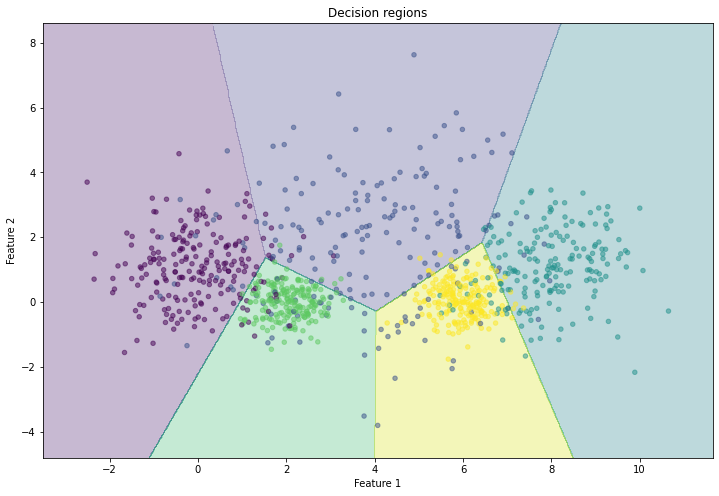

In [44]:
mn_cl = MultiNomialLogRegClassifier()
mn_cl.fit(X_train, t_multi_train, eta=0.15, tol=0.001)
acc = accuracy(mn_cl.predict(X_val), t_multi_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train, t_multi_train, mn_cl)

We see that the borders are slightly different around the lime green and yellow data points. The left and right downward lines wrap around these areas more tightly than in the "one-vs-all" classifier. Interesting.

# Part 2: Multi-layer nerual network
## A first non-linear classifier

Now for the difficult part, neural networks. The multi layer perceptron classifier with only one hidden layer is implemented with the following code:

In [45]:
def logistic_diff(y):
    return y * (1 - y)

In [46]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        # Dimensionality of the hidden layer
        self.dim_hidden = dim_hidden
        
        self.activ = logistic
        
        self.activ_diff = logistic_diff
        
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        # First hidden layer
        z1 = X @ self.weights1
        a1 = self.activ(z1)
        
        # Output layer
        a1 = add_bias(a1, self.bias)
        z2 = a1 @ self.weights2
        a2 = self.activ(z2)
        
        hidden_outs = a1
        outputs = a2
        
        return hidden_outs, outputs
    
    def fit(self, X_train, t_train, lr=0.001, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a NxM matrix, N data points, M features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        lr is the learning rate
        """
        self.lr = lr
        
        # Turn t_train into a column vector, a N*1 matrix:
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            # The forward step:
            hidden_outs, outputs = self.forward(X_train_bias)
            # The delta term on the output node:
            out_deltas = (outputs - T_train)
            # The delta terms at the output of the hidden layer:
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The deltas at the input to the hidden layer:
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))  

            # Update the weights:
            self.weights2 -= self.lr * hidden_outs.T @ out_deltas
            self.weights1 -= self.lr * X_train_bias.T @ hiddenact_deltas 
            
    
    def predict(self, X):
        """Predict the class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

Now, lets tune!

In [47]:
epochs_range = np.array([1, 10, 100, 1000, 10000, 100000])
eta = 0.01
print('+---------------+----------+----------+')
print('| Learning rate |  Epochs  | Accuracy |')
print('+---------------+----------+----------+')
for epochs in epochs_range:
    cl = MLPBinaryLinRegClass()
    cl.fit(X_train, t2_train, lr=eta, epochs=epochs)
    acc = accuracy(cl.predict(X_val), t2_val)
    print(f'|{eta:10.2f}     |  {epochs:6}  |   {acc:.3f}  |')
print('+---------------+----------+----------+')

+---------------+----------+----------+
| Learning rate |  Epochs  | Accuracy |
+---------------+----------+----------+
|      0.01     |       1  |   0.604  |
|      0.01     |      10  |   0.464  |
|      0.01     |     100  |   0.694  |
|      0.01     |    1000  |   0.810  |
|      0.01     |   10000  |   0.926  |
|      0.01     |  100000  |   0.902  |
+---------------+----------+----------+


The accuracy increase with the number of epochs as expected, but it falls down after 10000. We therefor let _tol_=10000. Now lets look at different learning rates:

In [48]:
eta_range = np.array([0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.3, 0.35])
epochs = 10000
print('+---------------+----------+----------+')
print('| Learning rate |  Epochs  | Accuracy |')
print('+---------------+----------+----------+')
for eta in eta_range:
    cl = MLPBinaryLinRegClass()
    cl.fit(X_train, t2_train, lr=eta, epochs=epochs)
    acc = accuracy(cl.predict(X_val), t2_val)
    print(f'|{eta:10.4f}     |  {epochs:6}  |   {acc:.3f}  |')
print('+---------------+----------+----------+')
# Need to include this to block warnings that come at the smaller learning rates
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

+---------------+----------+----------+
| Learning rate |  Epochs  | Accuracy |
+---------------+----------+----------+
|    0.0001     |   10000  |   0.902  |
|    0.0010     |   10000  |   0.920  |
|    0.0100     |   10000  |   0.922  |


/tmp/ipykernel_612/3743801831.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


|    0.1000     |   10000  |   0.806  |
|    0.1500     |   10000  |   0.834  |
|    0.2000     |   10000  |   0.644  |
|    0.3000     |   10000  |   0.706  |
|    0.3500     |   10000  |   0.476  |
+---------------+----------+----------+


(ignore the warning) This classifier seems to prefer smaller learning rates compared to our previous ones. The best learning rate in this case is $\eta$ = 0.001, which we will now use to fit and plot our multi layer perceptron classifier:

Accuracy on the validation set: 0.908


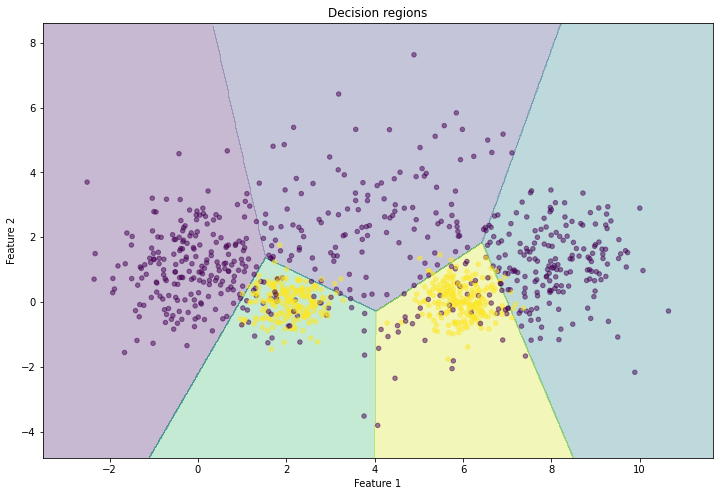

In [49]:
mlp_cl = MLPBinaryLinRegClass()
mlp_cl.fit(X_train, t2_train, lr=0.001, epochs=10000)
acc = accuracy(mlp_cl.predict(X_val), t2_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train, t2_train, mn_cl)

Wow! This binary non-linear classifier seperates the two classes much better than the binary _linear_ classifiers we looked at in the beginning.

## Improving the MLP classifier

The improved version of the multi layer perceptron is written below:

In [50]:
# The improved version
class MLPBinaryLinRegClassImproved(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        # Dimensionality of the hidden layer
        self.dim_hidden = dim_hidden
        
        self.activ = logistic
        
        self.activ_diff = logistic_diff
        
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        # First hidden layer
        z1 = X @ self.weights1
        a = self.activ(z1)
        
        # Output layer
        a = add_bias(a, self.bias)
        z2 = a @ self.weights2
        y = self.activ(z2)
        
        hidden_outs = a
        outputs = y
        
        return hidden_outs, outputs
    
    def fit(self, X_train, t_train, X_val=None, t_val=None, lr=0.1, tol=1e-3, n_epochs_no_update=5):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a NxM matrix, N data points, M features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        lr is the learning rate
        """
        self.lr = lr
        
        self.losses = losses = []
        self.accuracies = accuracies = []
        self.val_losses = val_losses = []
        self.val_accuracies = val_accuracies = []
        
        # Turn t_train into a column vector, a N*1 matrix:
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden+1, dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        self.epochs = 0
        prev_loss = 0
        no_update = 0
        while (no_update < n_epochs_no_update):
            # One epoch
            # The forward step:
            hidden_outs, outputs = self.forward(X_train_bias)
            # The delta term on the output node:
            out_deltas = (outputs - T_train)
            # The delta terms at the output of the hidden layer:
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The deltas at the input to the hidden layer:
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))  

            # Update the weights:
            self.weights2 -= self.lr * hidden_outs.T @ out_deltas
            self.weights1 -= self.lr * X_train_bias.T @ hiddenact_deltas 
            
            # Calcuate the cross-entropy loss and accuracy:
            y = self.predict_probability(X_train)
            loss = -np.mean(T_train * np.log(y) + (1-T_train) * np.log(1 - y))
            acc = accuracy(self.predict(X_train), T_train)
            losses.append(loss)
            accuracies.append(acc)
            
            if (isinstance(X_val, np.ndarray) == True) and (isinstance(t_val, np.ndarray) == True):
                y = self.predict_probability(X_val)
                T_val = t_val.reshape(-1, 1)
                val_loss = -np.mean(T_val * np.log(y) + (1-T_val)*np.log(1 - y))
                val_acc = accuracy(self.predict(X_val), T_val)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            # Check if the loss has changed significantly
            if (abs(loss - prev_loss) < tol):
                no_update += 1
            else:
                no_update = 0
                
            # Update loss and amount of epochs
            prev_loss = loss
            self.epochs += 1
    
    def predict(self, X):
        """Predict the class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)
    
    def predict_probability(self, X):
        """Predict the probability for being in the positive class given X"""
        Z = add_bias(X, self.bias)
        hidden_outs, outputs = self.forward(Z)
        return outputs

Tuning this improved classifier has been no easy task. After alot of trial and error the best hyper-parametes I found was _lr_ = 0.001, _tol_ = 1e-5 and _dim_hidden_ = 6 on the scaled dataset. But even with these parameters the classifier is quite unstable, where accuracies range from 0.6 to over 0.92 between runs. The following run of the improved classifier is one of the better ones:

Accuracy on the validation set: 0.898


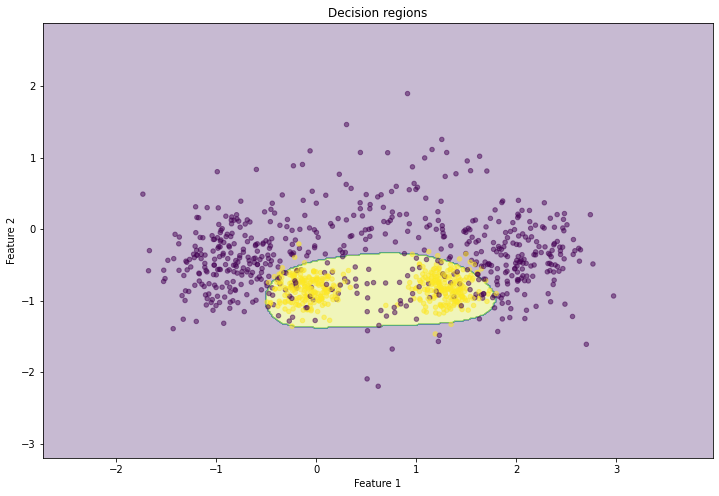

In [51]:
mlp_cl1 = MLPBinaryLinRegClassImproved(dim_hidden = 6)
mlp_cl1.fit(X_train_s, t2_train, lr=0.001, tol=1e-5)
acc = accuracy(mlp_cl1.predict(X_val_s), t2_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train_s, t2_train, mlp_cl1)

This is very impressive, compared to before! The classifier have really well pinpointed the yellow class with small circles around its corresponding data points.

In [52]:
mlp_cl = MLPBinaryLinRegClassImproved(dim_hidden = 6)

mlp_cl.fit(X_train_s, t2_train, X_val_s, t2_val, lr=0.001, tol=1e-5)
training_loss = mlp_cl.losses
training_acc = mlp_cl.accuracies
validation_loss = mlp_cl.val_losses
validation_acc = mlp_cl.val_accuracies

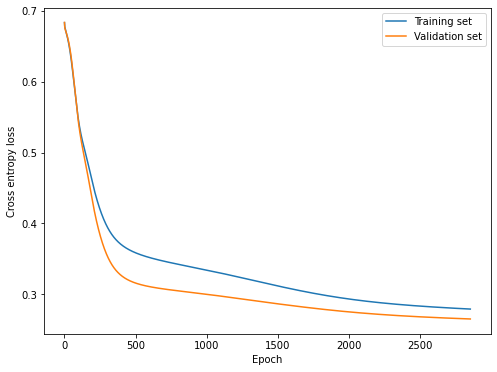

In [53]:
plt.figure(figsize=(8,6))
plt.plot(training_loss, label='Training set')
plt.plot(validation_loss, label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')
plt.legend()
plt.show()

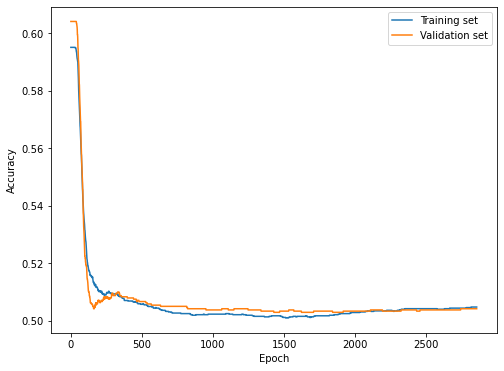

In [54]:
plt.figure(figsize=(8,6))
plt.plot(training_acc, label='Training set')
plt.plot(validation_acc, label='Validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The loss decrease are more similar now than the one we saw in the binary case, but the validation is still smaller than the training. Maybe this acctually is what is expected. The accuracy though are quite small for some reason, which is odd compared to when we tuned the parameters.

In [55]:
accs = np.zeros(10)
for i in range(10):
    mlp_cl = MLPBinaryLinRegClassImproved(dim_hidden = 6)
    mlp_cl.fit(X_train_s, t2_train, X_val_s, t2_val, lr=0.001, tol=1e-5)
    acc = accuracy(mlp_cl.predict(X_val_s), t2_val)
    accs[i] = acc
print(f'Mean: {accs.mean():.3f}')
print(f'Std: {accs.std():.4f}')

Mean: 0.900
Std: 0.0030


We see that we consistantly get good results.

## Multi-class Neural Network

Bellow is my attempt to make the multi-class neural network, but ultimatly it failed and I cant figure out how to fix it. I tried doing the same as in the 'one-vs-rest' by making 5 seperate multi layer perceptron for each class and than fit each one with their own one-hot target vectors, but it would give an error when trying to predict the probability of being in each class.

In [56]:
class MultiClassNeuralNetwork():
    
    def fit(self, X_train, t_train, lr=0.1, tol=1e-3, n_epochs_no_update=5):
        # One-hot encode the target data:
        self.n_class = n_class = 5
        t_one_hot = np.zeros((t_train.shape[0], n_class))
        for i, t_class in enumerate(t_train):
            t_one_hot[i][t_class] = 1
            
        # Create a list of untrained multi layer perceptron classifiers for each class
        self.classifiers = classifiers = [MLPBinaryLinRegClassImproved(dim_hidden=6) for x in range(n_class)]
        
        # Train each classifier with their corresponding one-hot target column
        for i, cl in enumerate(classifiers):
            cl.fit(X_train, t_one_hot[:,i], lr=lr, tol=tol)
            
    def predict(self, X):
        # Choose the class with the highest probability
        return np.argmax(self.predict_probability(X), axis=1)
    
    def predict_probability(self, X):
        """Fills each column of a matrix with the predicted probability for being
        in one class given a input X and retruns it"""
        prob_matrix = np.zeros((X.shape[0], self.n_class))
        for j in range(self.n_class):
            prob_matrix[:,j] = self.classifiers[j].predict_probability(X).reshape(1,-1)
        return prob_matrix

The fitting work fine (although it's quite slow)

In [66]:
mc_nn = MultiClassNeuralNetwork()
mc_nn.fit(X_train, t_multi_train, lr=0.001, tol=1e-3)

but when trying to calculate the accuracy the error comes up:

Accuracy on the validation set: 0.77


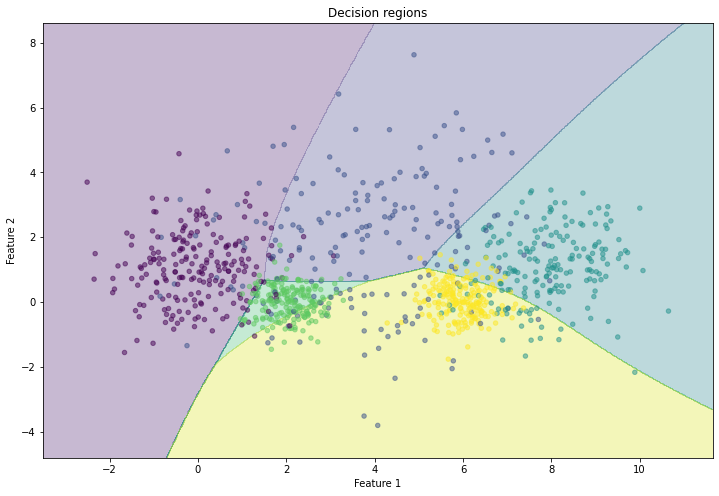

In [69]:
acc = accuracy(mc_nn.predict(X_val), t_multi_val)
print(f'Accuracy on the validation set: {acc}')
plot_decision_regions(X_train, t_multi_train, mc_nn)

NOTE: I was able to sorta fix the code at the last minute and could not tune it better because of time.

# Part 3: Final testing
## Binary task (X, t2)

We perform the final testing of the binary classifiers with the following code:

In [70]:
lr_cl = NumpyLinRegClass()
log_cl = LogisticRegressionClassifier()
mlp_cl = MLPBinaryLinRegClass()

X = [X_train, X_val, X_test]
T = [t2_train, t2_val, t2_test]
sets = ['Training', 'Validation', 'Test']

print('-----------+-------------------+---------------------+------------------------')
print('           | Linear Regression | Logistic Regression | Multi Layer Perceptron ')
print('-----------+-------------------+---------------------+------------------------')
for i in range(3):
    x = X[i]
    t = T[i]
    lr_cl.fit(X_train, t2_train, eta=0.079, epochs=900)
    log_cl.fit(X_train, t2_train, eta=0.25, tol=0.00001)
    mlp_cl.fit(X_train, t2_train, lr=0.001, epochs=10000)
    # Evaluate accuracies
    lr_acc = accuracy(lr_cl.predict(x), t)
    log_acc = accuracy(log_cl.predict(x), t)
    mlp_acc = accuracy(mlp_cl.predict(x), t)
    print(f'{sets[i]:10} | {lr_acc:11.3f} {log_acc:20.3f} {mlp_acc:22.3f}')
print('-----------+-------------------+---------------------+------------------------')

-----------+-------------------+---------------------+------------------------
           | Linear Regression | Logistic Regression | Multi Layer Perceptron 
-----------+-------------------+---------------------+------------------------
Training   |       0.715                0.720                  0.885
Validation |       0.766                0.760                  0.908
Test       |       0.716                0.728                  0.902
-----------+-------------------+---------------------+------------------------


For all the classifiers we see that the best performance is on the validation set, and that the test set suprisingly performes better than the training set. We also see that the multi layer perceptron classifier performs much better than the other two classifiers. The linear and logistic classifiers provide very similar accuracies, where the linear classifier performs sligthly better on the training and test set, while the logistic classifer performes slightly better on the validation set. In terms of the different classifiers was this expected, since we saw from the plots earlier that the linear and logistic decision boundaries were very similar, while the multi layer perceptron was much better to seperate the two classes from eachother.

## Multi-class task (X_, t_multi)

Now we will do the same as above for the multi-class classifiers. Since I was not able to create the multi-class neural network, we will only be able to look at the 'one-vs-rest' and multinomial logistic classifiers.

In [68]:
ovr_cl = MultiClassLogRegClassifier()
mn_log_cl = MultiNomialLogRegClassifier()
mc_nn_cl = MultiClassNeuralNetwork()

X = [X_train, X_val, X_test]
T = [t_multi_train, t_multi_val, t_multi_test]
sets = ['Training', 'Validation', 'Test']

print('-----------+-------------+----------------------+----------------------------')
print('           | One-vs-rest | Multinomial Logistic | Multi-class Neural Network ')
print('-----------+-------------+----------------------+----------------------------')
for i in range(3):
    x = X[i]
    t = T[i]
    ovr_cl.fit(X_train, t_multi_train, eta=0.2, tol=0.001)
    mn_log_cl.fit(X_train, t_multi_train, eta=0.15, tol=0.001)
    mc_nn_cl.fit(X_train, t_multi_train, lr=0.01, tol=1e-2)
    # Evaluate accuracies
    ovr_acc = accuracy(ovr_cl.predict(x), t)
    mn_acc = accuracy(mn_log_cl.predict(x), t)
    #mc_acc = accuracy(mc_nn_cl.predict(x), t)
    mc_acc = 0
    print(f'{sets[i]:10} | {ovr_acc:8.3f} {mn_acc:18.3f} {mc_acc:22}')
print('-----------+-------------+----------------------+----------------------------')

-----------+-------------+----------------------+----------------------------
           | One-vs-rest | Multinomial Logistic | Multi-class Neural Network 
-----------+-------------+----------------------+----------------------------
Training   |    0.843              0.854                      0
Validation |    0.862              0.864                      0
Test       |    0.826              0.838                      0
-----------+-------------+----------------------+----------------------------


For both classifiers the validation set gives the best performance, while the training set gives better performace than the test set. This is more of what is expected compared what we saw for the binary classifiers above. We also see that the multinomial logistic classifier is slightly better than the 'one-vs-rest' classifier. Sadly we don't have any accuracies for the neural network, but I imagine that it would be better than all the other classifiers.

Thank you for reading!

END